In [1]:
import xarray as xr
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pysumma as ps
import pysumma.plotting as psp
import warnings

# pysumma has many depreciated packages, this ignores their warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
# for testing 
!echo "paradise_WY24.nc" > forcings/forcing_file_list.txt

In [13]:
executable = 'summa.exe'
filemanager = './model/settings/file_manager.txt'

# Create a pySUMMA simulation object
s = ps.Simulation(executable, filemanager)


# Set the simulation start and end times from forcing file
with open('./forcings/forcing_file_list.txt', 'r') as file:
    # Read the contents
    forcing_file = file.read().replace("'", "")
forcing = xr.open_dataset('./forcings/'+forcing_file.strip(), engine='netcdf4')
time = forcing['time']

dt64 = np.datetime64(time.isel(time=0).values)
dt = pd.to_datetime(dt64)
start = dt.strftime('%Y-%m-%d %H:%M')
dt64 = np.datetime64(time.isel(time=-1).values)
dt = pd.to_datetime(dt64)
end = dt.strftime('%Y-%m-%d %H:%M')

s.manager['simStartTime'] = start
s.manager['simEndTime'] = end

# Add in some additional variables so we can demonstrate plotting capabilities
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerTemp', 'mLayerDepth', 'mLayerHeight',
              'mLayerLiqFluxSoil', 'mLayerVolFracIce', 'mLayerVolFracLiq', 
              'mLayerVolFracWat','mLayerMatricHead', 'iLayerHeight', 'scalarSnowDepth', 'nSnow']

# Create the new variables
for var in layer_vars:
    s.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s.output_control.options])
for var in all_vars:
    s.output_control[var] = output_settings

out_name = os.path.splitext(forcing_file)[0]
# Run the model, specify the output suffix
s.run('local', run_suffix=out_name)

In [14]:
s.status

'Success'

In [19]:
df = pd.read_csv('./snotel_csvs/paradise_WY24.csv', index_col=0, parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)


In [20]:
depth = s.output.isel(hru=0)['iLayerHeight']
temp = s.output.isel(hru=0)['mLayerTemp']
density = s.output.isel(hru=0)['mLayerVolFracWat']

In [25]:
snow_depth_obs = df.loc[pd.to_datetime(depth.time.values.min()):]['SNOWDEPTH'].resample('D').max()  * 2.54/100
# replace below zero values with 0
snow_depth_obs[snow_depth_obs < 0] = 0
# replace nan values with nan
snow_depth_obs[abs(snow_depth_obs.diff()) > 0.25] = np.nan
# interpolate missing values
snow_depth_obs = snow_depth_obs.interpolate()

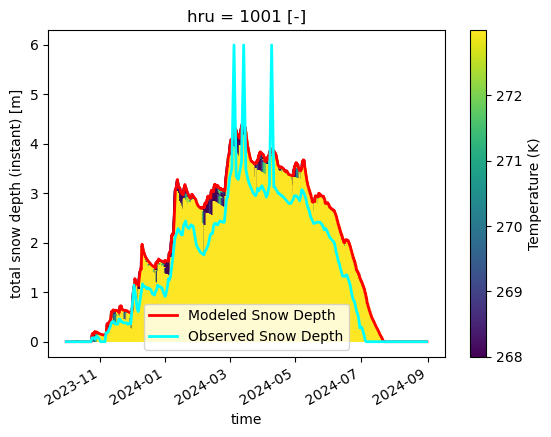

In [26]:
fig, ax = plt.subplots()
psp.layers(temp, depth, colormap='viridis', plot_soil=False, plot_snow=True, cbar_kwargs={'label': 'Temperature (K)', 'ticks':np.arange(268,273,1)}, variable_range=[268, 273], ax=ax)
s.output['scalarSnowDepth'].plot(color='red', linewidth=2, ax=ax, label='Modeled Snow Depth');
snow_depth_obs.plot(color='cyan', linewidth=2, ax=ax, label='Observed Snow Depth');
ax.legend()